In [329]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

-- -- -- -- -- -- 

## Data Cleaning

This section covers the data cleaning process to ensure data quality for analysis.

In [330]:
# Load the census data
df = pd.read_csv('T1_A25census-9.csv')

# Remove the first unnamed index column if it exists
if df.columns[0] == '' or df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

# Display first few rows to inspect the data structure
df.head()

,House Number,Street,First Name,Surname,Age,Relationship to Head of House,Marital Status,Gender,Occupation,Infirmity,Religion
0,1,Guildfast Lane,June,Cooper,52,Head,Divorced,Female,Unemployed,NaN,Christian
1,1,Guildfast Lane,Rita,Cooper,10,Daughter,NaN,Female,Student,NaN,NaN
2,2,Guildfast Lane,Melanie,Atkinson,52,Head,Married,Female,"Producer, television/film/video",NaN,Catholic
3,2,Guildfast Lane,Stuart,Atkinson,53,Husband,Married,Male,Aid worker,NaN,Christian
4,3,Guildfast Lane,Donna,Finch,44,Head,Married,Female,Translator,NaN,NaN


In [331]:
# Check data info
print(df.shape)
print(df.info())
print(df.describe())

(10594, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10594 entries, 0 to 10593
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   House Number                   10594 non-null  object
 1   Street                         10594 non-null  object
 2   First Name                     10594 non-null  object
 3   Surname                        10594 non-null  object
 4   Age                            10594 non-null  object
 5   Relationship to Head of House  9812 non-null   object
 6   Marital Status                 7849 non-null   object
 7   Gender                         10594 non-null  object
 8   Occupation                     10594 non-null  object
 9   Infirmity                      106 non-null    object
 10  Religion                       4340 non-null   object
dtypes: object(11)
memory usage: 910.6+ KB
None
       House Number        Street First Name Surname    Age  \
c

In [332]:
# Check for missing values
df.isnull().sum()

House Number                         0
Street                               0
First Name                           0
Surname                              0
Age                                  0
Relationship to Head of House      782
Marital Status                    2745
Gender                               0
Occupation                           0
Infirmity                        10488
Religion                          6254
dtype: int64

In [333]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check for blank spaces (spaces made with spacebar) - these need to be converted to NaN
print("\nChecking for whitespace-only entries...")
whitespace_found = False
for col in df.columns:
    if df[col].dtype == 'object':
        # Count entries that are only whitespace
        whitespace_count = df[col].astype(str).str.strip().eq('').sum()
        if whitespace_count > 0:
            print(f"  {col}: {whitespace_count} whitespace-only entries found")
            # Replace whitespace-only entries with NaN for proper handling
            df.loc[df[col].astype(str).str.strip() == '', col] = np.nan
            whitespace_found = True

Number of duplicate rows: 0

Checking for whitespace-only entries...
  First Name: 1 whitespace-only entries found
  Age: 1 whitespace-only entries found
  Relationship to Head of House: 2 whitespace-only entries found
  Occupation: 3 whitespace-only entries found
  Infirmity: 16 whitespace-only entries found


In [334]:
# Clean column names - remove any leading/trailing whitespace
df.columns = df.columns.str.strip()

# Clean text fields - remove extra spaces from names and street addresses
df['First Name'] = df['First Name'].str.strip()
df['Surname'] = df['Surname'].str.strip()
df['Street'] = df['Street'].str.strip()

# Check unique values in key categorical columns to see what needs standardization
print("Marital Status unique values:", df['Marital Status'].unique())
print("Gender unique values:", df['Gender'].unique())
print("Religion unique values (first 10):", df['Religion'].unique()[:10])

Marital Status unique values: ['Divorced' nan 'Married' 'Single' 'Widowed' 'M' 'D' 'S' 'W']
Gender unique values: ['Female' 'Male' 'M' 'F' 'female' 'male' 'f' 'm']
Religion unique values (first 10): ['Christian' nan 'Catholic' 'Methodist' 'Sikh' 'Muslim' 'Quaker' 'Jewish'
 'Sith' 'Bahai']


In [335]:
# Convert Age to numeric - handle any non-numeric values by converting to NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Round to integers
df['Age'] = df['Age'].round()
df['Age'] = df['Age'].astype('Int64')

# Check for data quality issues in age column
print("Age column statistics:")
print(f"  Minimum age: {df['Age'].min()}")
print(f"  Maximum age: {df['Age'].max()}")
print(f"  Missing values: {df['Age'].isnull().sum()}")
print(f"  Ages over 120 (unrealistic): {(df['Age'] > 120).sum()}")
print(f"  Negative ages (invalid): {(df['Age'] < 0).sum()}")

Age column statistics:
  Minimum age: 0
  Maximum age: 115
  Missing values: 1
  Ages over 120 (unrealistic): 0
  Negative ages (invalid): 0


In [336]:
# Remove unrealistic ages
df.loc[df['Age'] > 110, 'Age'] = np.nan
df.loc[df['Age'] < 0, 'Age'] = np.nan

# Standardize marital status
df['Marital Status'] = df['Marital Status'].str.strip()
df['Marital Status'] = df['Marital Status'].replace('NA', 'N/A')  # N/A for minors
df['Marital Status'] = df['Marital Status'].replace('na', 'N/A')
df['Marital Status'] = df['Marital Status'].replace('', np.nan)

# Replace abbreviations with full words for consistency
df['Marital Status'] = df['Marital Status'].replace('M', 'Married')
df['Marital Status'] = df['Marital Status'].replace('D', 'Divorced')
df['Marital Status'] = df['Marital Status'].replace('S', 'Single')
df['Marital Status'] = df['Marital Status'].replace('W', 'Widowed')

# Standardize gender to only 'Male' or 'Female'
df['Gender'] = df['Gender'].str.strip()
df['Gender'] = df['Gender'].replace('M', 'Male')
df['Gender'] = df['Gender'].replace('m', 'Male')
df['Gender'] = df['Gender'].replace('male', 'Male')
df['Gender'] = df['Gender'].replace('F', 'Female')
df['Gender'] = df['Gender'].replace('f', 'Female')
df['Gender'] = df['Gender'].replace('female', 'Female')

print("Gender values after standardization:", df['Gender'].unique())
print(f"Gender distribution:\n{df['Gender'].value_counts()}")

Gender values after standardization: ['Female' 'Male']
Gender distribution:
Gender
Female    5599
Male      4995
Name: count, dtype: int64


In [337]:
# Clean religion
df['Religion'] = df['Religion'].str.strip()
df['Religion'] = df['Religion'].replace('None', np.nan)
df['Religion'] = df['Religion'].replace('NA', np.nan)
df['Religion'] = df['Religion'].replace('', np.nan)

# Clean occupation
df['Occupation'] = df['Occupation'].str.strip()
df['Occupation'] = df['Occupation'].replace('', np.nan)

In [338]:
# Check relationship
print("Relationship values:", df['Relationship to Head of House'].unique())
df['Relationship to Head of House'] = df['Relationship to Head of House'].str.strip()
df['Relationship to Head of House'] = df['Relationship to Head of House'].replace('NA', np.nan)

Relationship values: ['Head' 'Daughter' 'Husband' 'Partner' 'Son' nan 'Lodger' 'Wife'
 'Granddaughter' 'Grandson' 'Sibling' 'Visitor' 'Step-Daughter'
 'Adopted Daughter' 'Cousin' 'Step-Son' 'Neice' 'Nephew' 'Adopted Son'
 'Adopted Grandson' 'Adopted Granddaughter']


In [339]:
# Check infirmity
print("Infirmity values:", df['Infirmity'].unique())
df['Infirmity'] = df['Infirmity'].str.strip()
df['Infirmity'] = df['Infirmity'].replace('None', np.nan)
df['Infirmity'] = df['Infirmity'].replace('', np.nan)

Infirmity values: [nan 'Mental Disability' 'Deaf' 'Unknown Infection' 'Disabled'
 'Physical Disability' 'Blind']


In [340]:
# Check street names and house numbers
print("Number of unique streets:", df['Street'].nunique())
print("Unique streets:", df['Street'].unique())

# Check for missing street or house number
print("\nMissing streets:", df['Street'].isnull().sum())
print("Missing house numbers:", df['House Number'].isnull().sum())

Number of unique streets: 105
Unique streets: ['Guildfast Lane' 'Hall Lane' 'Mistry Avenue' 'Thompson Villages'
 'Violet Street' 'Lisbon Heights' 'Long Canyon' 'Waterloo Fort'
 'Thedike Lane' 'Foster Run' 'Libra Ports' 'North Avenue'
 'Bassenthwaite Lane' 'Foster Street' 'Jackson Street' 'Magpie Lane'
 'Birminghamedge Road' 'Glasgow Street' 'Harrison Heights' 'Arrows Street'
 'Stoke Drive' 'Andrews Rue' 'Williams Light' 'Williams Lodge'
 'Aethelstan Road' 'Armstrong Common' 'Rice Plaza' 'Repton Spur'
 'Portsmouthtraps Street' 'Lovecross Lane' 'Manor Plain'
 'Templeshy Street' 'Alba Union' 'Robinson Drive' 'Potter Spurs'
 'Fish Mews' 'Column Manor' 'Taylor Street' 'Plymouth Via' 'Sydney Skyway'
 'Preston Way' 'Anvil Street' 'Chapman Avenue' 'Wessex Drive'
 'March Bridge' 'Farthing Avenue' 'Bassenthwaitecurl Avenue'
 'Telegraph Circle' 'Windsor Crescent' 'Wall Bypass' 'Yucca Lane'
 'Brooks Drive' 'Trawler Island' 'Russell Drive' 'Stevens Brook'
 'Fornaxbraid Lane' 'Gregory Drive' 'Canter

In [341]:
# Check everything one last time
print("Final Check\n")
print("Age type:", df['Age'].dtype)
print("Age min:", df['Age'].min(), "max:", df['Age'].max())
print("Age nulls:", df['Age'].isnull().sum())

print("\nGender values:", df['Gender'].unique())
print("Gender counts:")
print(df['Gender'].value_counts())

print("\nMarital Status:", df['Marital Status'].unique())
print("Marital Status nulls:", df['Marital Status'].isnull().sum())

print("\nReligion sample:", df['Religion'].dropna().unique()[:10])
print("Religion nulls:", df['Religion'].isnull().sum())

print("\n=== SUMMARY ===")
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

Final Check

Age type: Int64
Age min: 0 max: 108
Age nulls: 3

Gender values: ['Female' 'Male']
Gender counts:
Gender
Female    5599
Male      4995
Name: count, dtype: int64

Marital Status: ['Divorced' nan 'Married' 'Single' 'Widowed']
Marital Status nulls: 2745

Religion sample: ['Christian' 'Catholic' 'Methodist' 'Sikh' 'Muslim' 'Quaker' 'Jewish'
 'Sith' 'Bahai' 'Jedi']
Religion nulls: 6254

=== SUMMARY ===
Shape: (10594, 11)

Missing values:
House Number                         0
Street                               0
First Name                           1
Surname                              0
Age                                  3
Relationship to Head of House      784
Marital Status                    2745
Gender                               0
Occupation                           3
Infirmity                        10504
Religion                          6254
dtype: int64


In [342]:
# Final fixes
df['House Number'] = df['House Number'].astype(str).str.strip()

# Make sure age is integer
if df['Age'].dtype != 'Int64':
    df['Age'] = df['Age'].round().astype('Int64')

print("Gender:", df['Gender'].unique())
print("Age type:", df['Age'].dtype)

Gender: ['Female' 'Male']
Age type: Int64


-- -- -- -- -- --

### (a) What should be built on an unoccupied plot of land that the local government wishes to develop?

The task requires analyzing the census data to determine the most appropriate development. The options to consider are:

1. **High-density housing** - Should be built if the population is significantly expanding
2. **Low-density housing** - Should be built if the population is affluent and there is demand for large family housing
3. **Train station** - Should be built if there are many commuters (would relieve road pressure)
4. **Religious building** - Should be built if there is demand (there is already one Catholic place of worship)
5. **Emergency medical building** - Minor injuries centre (not a full hospital). Should be built if there are many injuries or future pregnancies likely
6. **Something else** - Alternative development option

We will analyze each option using the census data to make an informed recommendation.

In [343]:
# Basic stats
print("Population Overview\n")
print(f"Total population: {len(df)}")

# Count households
households = df.groupby(['Street', 'House Number']).ngroups
print(f"Total households: {households}")
print(f"Average household size: {len(df) / households:.2f}")

print("\nAge stats:")
print(df['Age'].describe())

Population Overview

Total population: 10594
Total households: 3460
Average household size: 3.06

Age stats:
count      10591.0
mean     34.796242
std       21.34167
min            0.0
25%           17.0
50%           34.0
75%           50.0
max          108.0
Name: Age, dtype: Float64


/var/folders/ql/b47wk6b932x3yf9lt49mf05m0000gn/T/ipykernel_75606/1677817314.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_data = df[df['Gender'] == 'Male'].groupby('Age_Group').size()
/var/folders/ql/b47wk6b932x3yf9lt49mf05m0000gn/T/ipykernel_75606/1677817314.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  female_data = df[df['Gender'] == 'Female'].groupby('Age_Group').size()


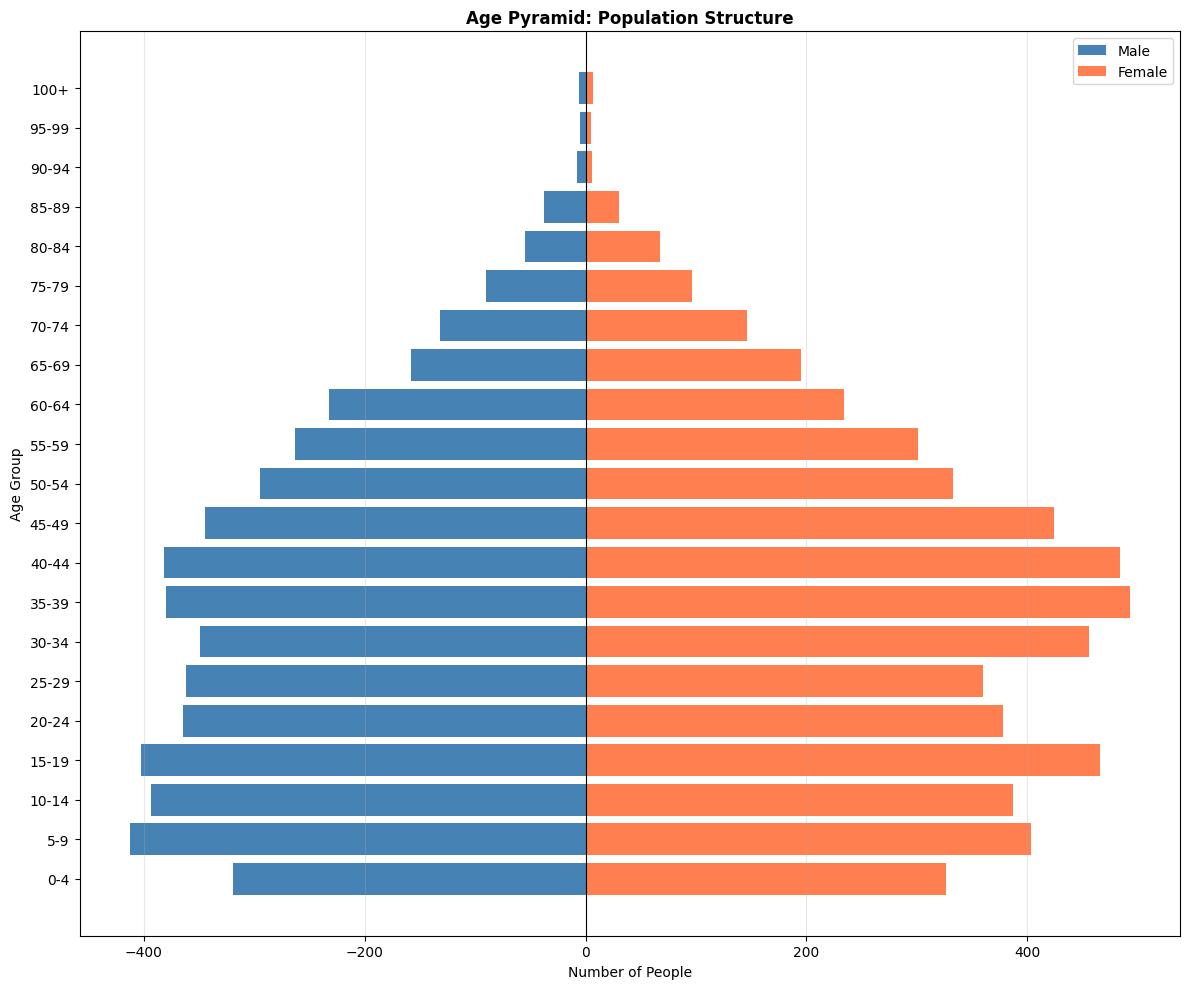

Figure 8: Age pyramid showing population structure by gender and age groups.

Analysis:
  - Children (0-17): 2745 (25.9%)
  - Working age (18-64): 6802 (64.2%)
  - Elderly (65+): 1044 (9.9%)


In [ ]:
# Age pyramid - shows population structure
# Create age groups
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 115]
age_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
              '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Separate by gender
male_data = df[df['Gender'] == 'Male'].groupby('Age_Group').size()
female_data = df[df['Gender'] == 'Female'].groupby('Age_Group').size()

# Create age pyramid
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(age_labels))

# Plot bars
ax.barh(y_pos, -male_data.values, color='steelblue', label='Male')
ax.barh(y_pos, female_data.values, color='coral', label='Female')

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels(age_labels)
ax.set_xlabel('Number of People', fontsize=10)
ax.set_ylabel('Age Group', fontsize=10)
ax.set_title('Age Pyramid: Population Structure', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add zero line
ax.axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("Figure 8: Age pyramid showing population structure by gender and age groups.")
print("\nAnalysis:")
print(f"  - Children (0-17): {len(df[df['Age'] < 18])} ({len(df[df['Age'] < 18])/len(df)*100:.1f}%)")
print(f"  - Working age (18-64): {len(df[(df['Age'] >= 18) & (df['Age'] < 65)])} ({len(df[(df['Age'] >= 18) & (df['Age'] < 65)])/len(df)*100:.1f}%)")
print(f"  - Elderly (65+): {len(df[df['Age'] >= 65])} ({len(df[df['Age'] >= 65])/len(df)*100:.1f}%)")

In [345]:
# Option 1: High-density housing
print("High-density Housing\n")
# Check if population is growing
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
print(f"Young adults (18-35): {len(young)} ({len(young)/len(df)*100:.1f}%)")
print(f"Children: {len(kids)} ({len(kids)/len(df)*100:.1f}%)")
total_young = len(young) + len(kids)
print(f"Total: {total_young} ({total_young/len(df)*100:.1f}%)")

High-density Housing

Young adults (18-35): 2827 (26.7%)
Children: 2745 (25.9%)
Total: 5572 (52.6%)


In [346]:
# Option 2: Low-density housing
print("Low-density Housing\n")
# Check household sizes
household_sizes = df.groupby(['Street', 'House Number']).size()
print(f"Average household size: {household_sizes.mean():.2f}")
large = (household_sizes >= 4).sum()
print(f"Large households (4+ people): {large} ({large/len(household_sizes)*100:.1f}%)")
very_large = (household_sizes >= 5).sum()
print(f"Very large households (5+ people): {very_large} ({very_large/len(household_sizes)*100:.1f}%)")

# Check for high-income occupations
keywords = ['engineer', 'manager', 'director', 'doctor', 'lawyer']
high_income = df[df['Occupation'].str.contains('|'.join(keywords), case=False, na=False)]
print(f"High-income occupations: {len(high_income)} ({len(high_income)/len(df)*100:.1f}%)")

Low-density Housing

Average household size: 3.06
Large households (4+ people): 1307 (37.8%)
Very large households (5+ people): 620 (17.9%)
High-income occupations: 1167 (11.0%)


In [347]:
# Option 3: Train station
print("Train Station\n")
# Find commuters
# Students are identified by occupation containing 'student' or 'university'
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
print(f"Students: {len(students)} ({len(students)/len(df)*100:.1f}%)")

# People with jobs
# These are potential commuters who work in other cities
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
print(f"Employed (potential commuters): {len(employed)} ({len(employed)/len(df)*100:.1f}%)")

# Total potential commuters - this is the key metric for train station justification
total = len(students) + len(employed)
print(f"Total potential commuters: {total} ({total/len(df)*100:.1f}%)")
print(f"\nNote: This represents {total/len(df)*100:.1f}% of the population who would benefit from a train station.")

Train Station

Students: 2904 (27.4%)
Employed (potential commuters): 5582 (52.7%)
Total potential commuters: 8486 (80.1%)

Note: This represents 80.1% of the population who would benefit from a train station.


In [348]:
# Option 4: Religious building
print("Religious Building\n")
religion_counts = df['Religion'].value_counts()
print("Religion counts:")
print(religion_counts)
print(f"\nWith religion: {df['Religion'].notna().sum()} ({df['Religion'].notna().sum()/len(df)*100:.1f}%)")
print(f"No religion: {df['Religion'].isna().sum()} ({df['Religion'].isna().sum()/len(df)*100:.1f}%)")

# Check Catholics
catholics = df[df['Religion'] == 'Catholic']
print(f"Catholics: {len(catholics)} ({len(catholics)/len(df)*100:.1f}%)")

Religious Building

Religion counts:
Religion
Christian    2317
Catholic     1180
Methodist     611
Muslim        136
Sikh           55
Jewish         32
Bahai           2
Undecided       2
Quaker          1
Sith            1
Jedi            1
Buddist         1
Nope            1
Name: count, dtype: int64

With religion: 4340 (41.0%)
No religion: 6254 (59.0%)
Catholics: 1180 (11.1%)


In [349]:
# Option 5: Emergency medical building
print("Emergency Medical Building\n")
# Check for people with infirmities or medical conditions
infirm = df['Infirmity'].notna().sum()
print(f"People with infirmities: {infirm} ({infirm/len(df)*100:.1f}%)")
if infirm > 0:
    print("Infirmity types:")
    print(df['Infirmity'].value_counts())

# Women of childbearing age - potential for future pregnancies
women = df[(df['Gender'] == 'Female') & (df['Age'] >= 18) & (df['Age'] <= 45)]
print(f"\nWomen of childbearing age (18-45): {len(women)} ({len(women)/len(df)*100:.1f}%)")

# Children and elderly - populations that may need medical attention
kids = df[df['Age'] < 18]
elderly = df[df['Age'] >= 65]
print(f"Children (<18 years): {len(kids)} ({len(kids)/len(df)*100:.1f}%)")
print(f"Elderly (65+ years): {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")

Emergency Medical Building

People with infirmities: 90 (0.8%)
Infirmity types:
Infirmity
Physical Disability    24
Disabled               18
Mental Disability      14
Unknown Infection      13
Deaf                   12
Blind                   9
Name: count, dtype: int64

Women of childbearing age (18-45): 2465 (23.3%)
Children (<18 years): 2745 (25.9%)
Elderly (65+ years): 1044 (9.9%)


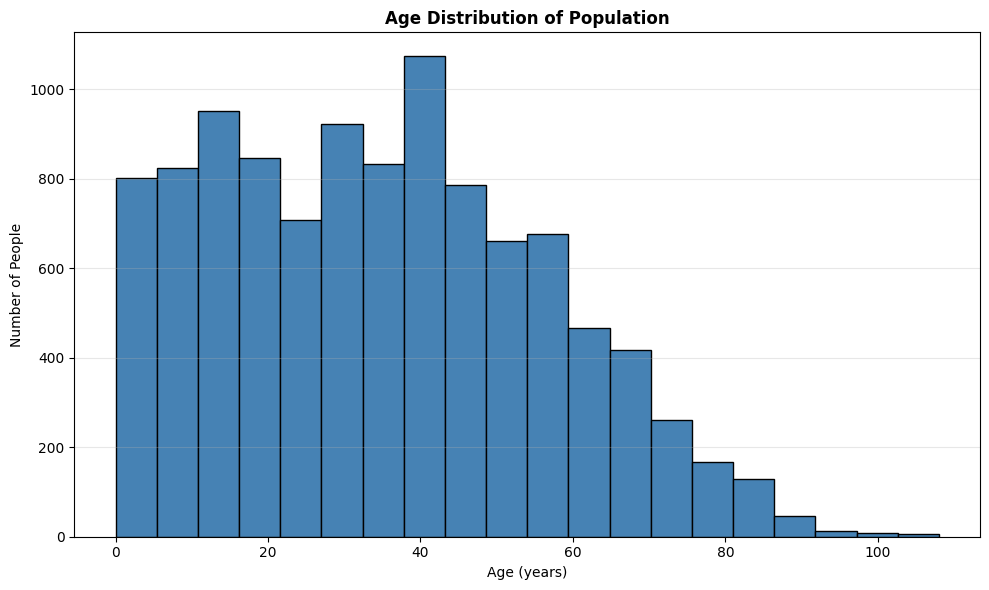

Figure 1: Age distribution of the population.


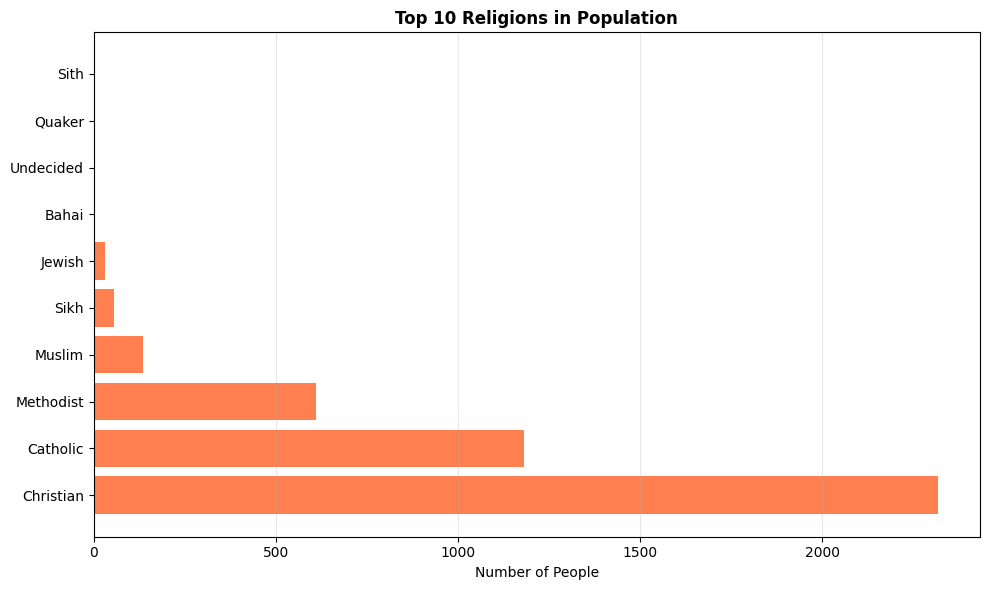

Figure 2: Top 10 religions in the population.


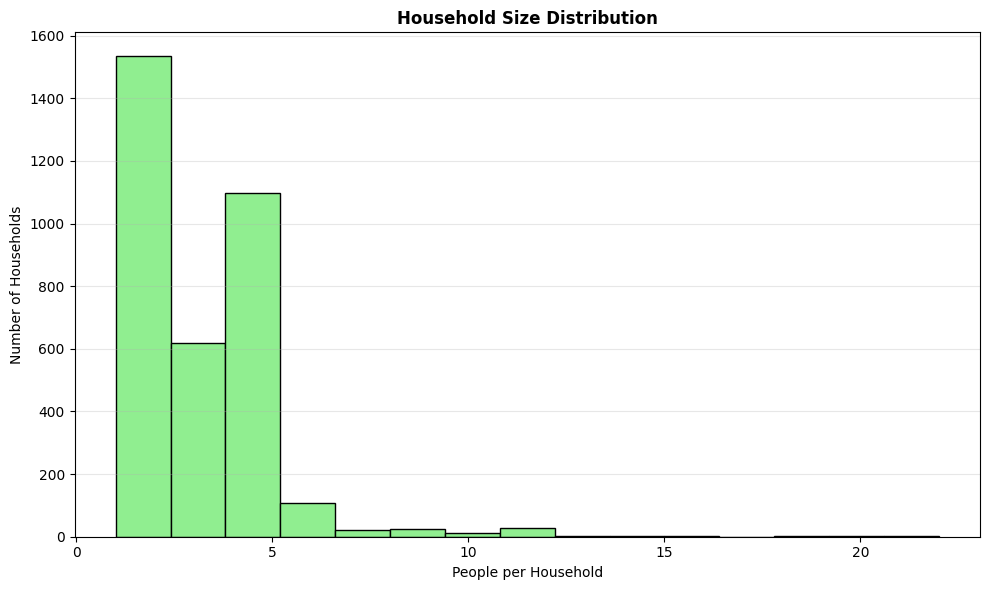

Figure 3: Distribution of household sizes.


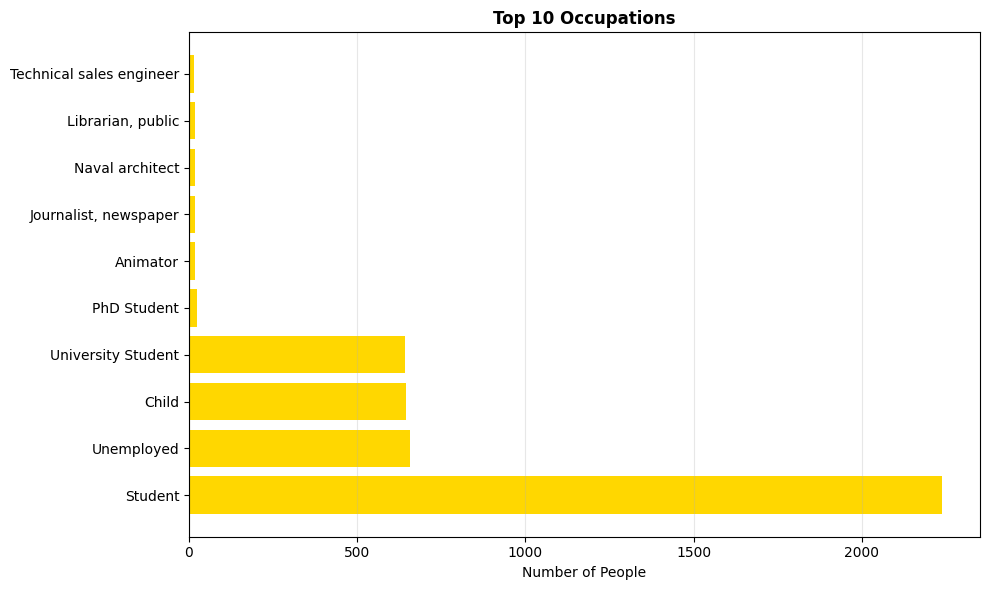

Figure 4: Top 10 occupations in the population.


In [350]:
# Create visualizations to support analysis

# Figure 1: Age distribution - shows population demographics
plt.figure(figsize=(10, 6))
plt.hist(df['Age'].dropna(), bins=20, edgecolor='black', color='steelblue')
plt.title('Age Distribution of Population', fontsize=12, fontweight='bold')
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Number of People', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 1: Age distribution of the population.")

# Figure 2: Religion distribution - relevant for religious building option
plt.figure(figsize=(10, 6))
religion_counts = df['Religion'].value_counts().head(10)
plt.barh(religion_counts.index, religion_counts.values, color='coral')
plt.title('Top 10 Religions in Population', fontsize=12, fontweight='bold')
plt.xlabel('Number of People', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 2: Top 10 religions in the population.")

# Figure 3: Household size distribution - relevant for housing options
plt.figure(figsize=(10, 6))
household_sizes = df.groupby(['Street', 'House Number']).size()
plt.hist(household_sizes, bins=15, edgecolor='black', color='lightgreen')
plt.title('Household Size Distribution', fontsize=12, fontweight='bold')
plt.xlabel('People per Household', fontsize=10)
plt.ylabel('Number of Households', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 3: Distribution of household sizes.")

# Figure 4: Top occupations - helps identify commuters and affluence
plt.figure(figsize=(10, 6))
occupation_counts = df['Occupation'].value_counts().head(10)
plt.barh(occupation_counts.index, occupation_counts.values, color='gold')
plt.title('Top 10 Occupations', fontsize=12, fontweight='bold')
plt.xlabel('Number of People', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 4: Top 10 occupations in the population.")

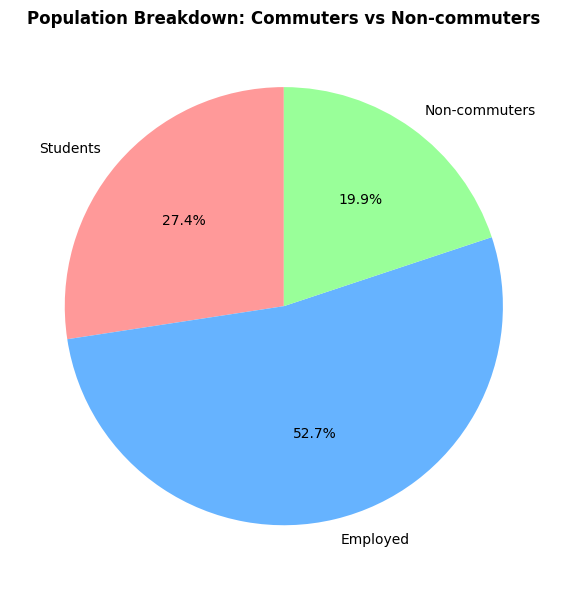

Figure 5: Population breakdown showing commuters (students and employed) vs non-commuters.


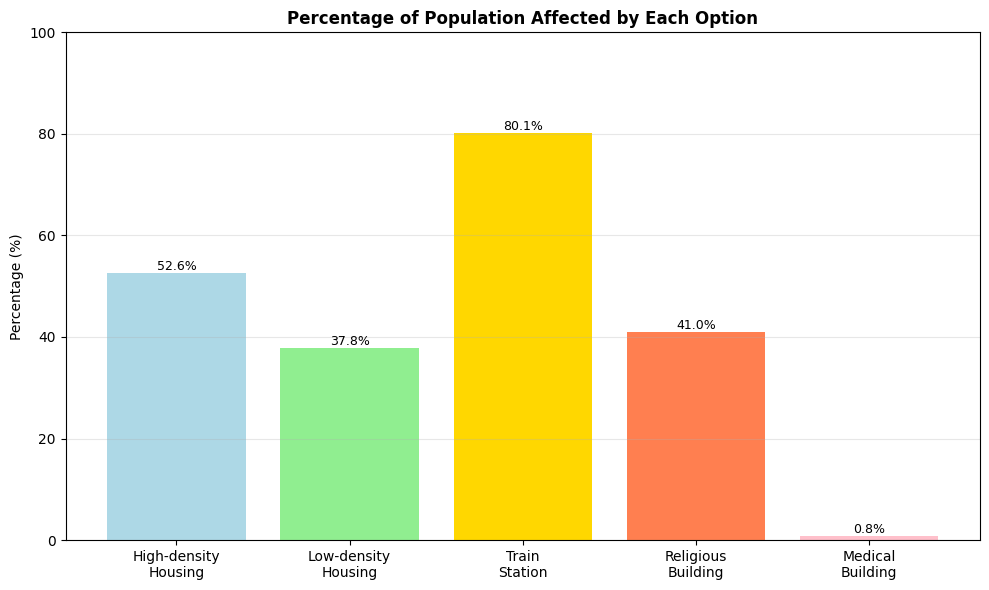

Figure 6: Comparison of all development options showing percentage of population affected by each.


In [351]:
# Additional visualization: Commuter analysis

# Figure 5: Pie chart showing commuter vs non-commuter breakdown
plt.figure(figsize=(10, 6))
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
non_commuters = len(df) - len(students) - len(employed)

commuter_data = [len(students), len(employed), non_commuters]
commuter_labels = ['Students', 'Employed', 'Non-commuters']
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.pie(commuter_data, labels=commuter_labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Population Breakdown: Commuters vs Non-commuters', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
print("Figure 5: Population breakdown showing commuters (students and employed) vs non-commuters.")

# Figure 6: Bar chart comparing all options
plt.figure(figsize=(10, 6))
options = ['High-density\nHousing', 'Low-density\nHousing', 'Train\nStation', 'Religious\nBuilding', 'Medical\nBuilding']
# Calculate percentages for each option
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
high_density_pct = (len(young) + len(kids)) / len(df) * 100

household_sizes = df.groupby(['Street', 'House Number']).size()
large_households = (household_sizes >= 4).sum()
low_density_pct = large_households / len(household_sizes) * 100

train_pct = (len(students) + len(employed)) / len(df) * 100

religion_pct = df['Religion'].notna().sum() / len(df) * 100

medical_pct = df['Infirmity'].notna().sum() / len(df) * 100

percentages = [high_density_pct, low_density_pct, train_pct, religion_pct, medical_pct]
bars = plt.bar(options, percentages, color=['lightblue', 'lightgreen', 'gold', 'coral', 'pink'])
plt.title('Percentage of Population Affected by Each Option', fontsize=12, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=10)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print("Figure 6: Comparison of all development options showing percentage of population affected by each.")

In [352]:
# Summary of all options
print("Summary")

# 1. High-density
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
print("\n1. HIGH-DENSITY HOUSING:")
print(f"   Young adults: {len(young)} ({len(young)/len(df)*100:.1f}%)")
print(f"   Children: {len(kids)} ({len(kids)/len(df)*100:.1f}%)")

# 2. Low-density
household_sizes = df.groupby(['Street', 'House Number']).size()
large = (household_sizes >= 4).sum()
keywords = ['engineer', 'manager', 'director', 'doctor', 'lawyer']
high_income = df[df['Occupation'].str.contains('|'.join(keywords), case=False, na=False)]
print("\n2. LOW-DENSITY HOUSING:")
print(f"   Large households: {large} ({large/len(household_sizes)*100:.1f}%)")
print(f"   High-income: {len(high_income)} ({len(high_income)/len(df)*100:.1f}%)")

# 3. Train station
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
total_commuters = len(students) + len(employed)
print("\n3. TRAIN STATION:")
print(f"   Students: {len(students)} ({len(students)/len(df)*100:.1f}%)")
print(f"   Employed: {len(employed)} ({len(employed)/len(df)*100:.1f}%)")
print(f"   Total commuters: {total_commuters} ({total_commuters/len(df)*100:.1f}%)")

# 4. Religious
catholics = df[df['Religion'] == 'Catholic']
christians = df[df['Religion'] == 'Christian']
others = df[(df['Religion'].notna()) & (df['Religion'] != 'Catholic') & (df['Religion'] != 'Christian')]
print("\n4. RELIGIOUS BUILDING:")
print(f"   Catholic: {len(catholics)} ({len(catholics)/len(df)*100:.1f}%)")
print(f"   Christian: {len(christians)} ({len(christians)/len(df)*100:.1f}%)")
print(f"   Other: {len(others)}")

# 5. Medical
infirm = df['Infirmity'].notna().sum()
women = df[(df['Gender'] == 'Female') & (df['Age'] >= 18) & (df['Age'] <= 45)]
kids2 = df[df['Age'] < 18]
elderly = df[df['Age'] >= 65]
print("\n5. EMERGENCY MEDICAL:")
print(f"   Infirmities: {infirm} ({infirm/len(df)*100:.1f}%)")
print(f"   Women 18-45: {len(women)} ({len(women)/len(df)*100:.1f}%)")
print(f"   Children: {len(kids2)} ({len(kids2)/len(df)*100:.1f}%)")
print(f"   Elderly: {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")

Summary

1. HIGH-DENSITY HOUSING:
   Young adults: 2827 (26.7%)
   Children: 2745 (25.9%)

2. LOW-DENSITY HOUSING:
   Large households: 1307 (37.8%)
   High-income: 1167 (11.0%)

3. TRAIN STATION:
   Students: 2904 (27.4%)
   Employed: 5582 (52.7%)
   Total commuters: 8486 (80.1%)

4. RELIGIOUS BUILDING:
   Catholic: 1180 (11.1%)
   Christian: 2317 (21.9%)
   Other: 843

5. EMERGENCY MEDICAL:
   Infirmities: 90 (0.8%)
   Women 18-45: 2465 (23.3%)
   Children: 2745 (25.9%)
   Elderly: 1044 (9.9%)



Unemployment by age group:
  <18: 0 unemployed out of 2797 (0.0%)
  18-24: 34 unemployed out of 1083 (3.1%)
  25-34: 139 unemployed out of 1574 (8.8%)
  35-44: 190 unemployed out of 1714 (11.1%)
  45-54: 163 unemployed out of 1361 (12.0%)
  55-64: 87 unemployed out of 975 (8.9%)
  65+: 42 unemployed out of 957 (4.4%)


/var/folders/ql/b47wk6b932x3yf9lt49mf05m0000gn/T/ipykernel_75606/2766927033.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unemployed_by_age = unemployed.groupby('Age_Category').size()
/var/folders/ql/b47wk6b932x3yf9lt49mf05m0000gn/T/ipykernel_75606/2766927033.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_age = df.groupby('Age_Category').size()


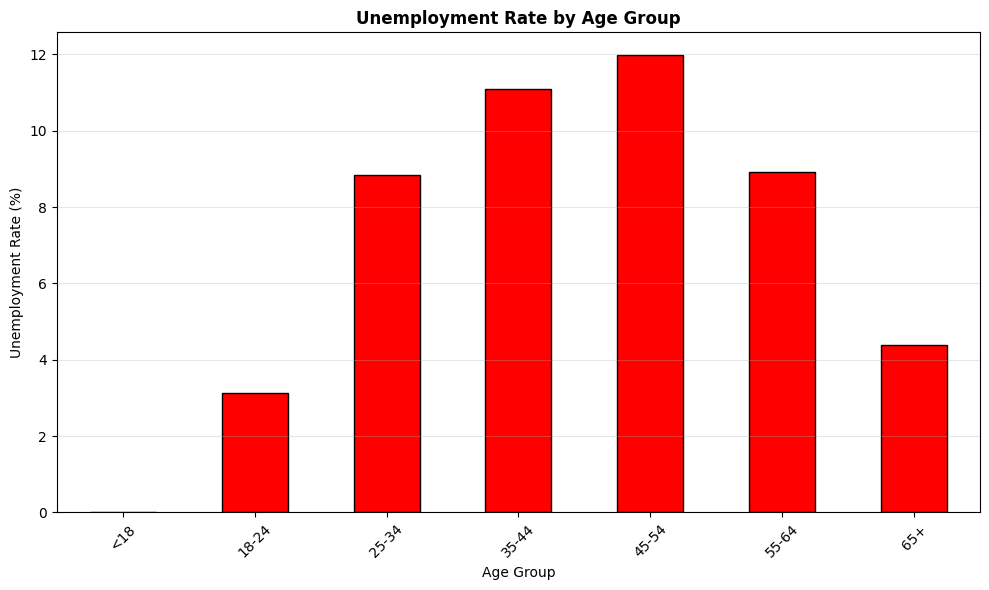

Figure 9: Unemployment rate across different age groups.


In [364]:
# Unemployment by age groups
# Create age groups for analysis
df['Age_Category'] = pd.cut(df['Age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], 
                            labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'])

# Check unemployment by age
unemployed = df[df['Occupation'].str.contains('unemployed|Unemployed', case=False, na=False)]
unemployed_by_age = unemployed.groupby('Age_Category').size()
total_by_age = df.groupby('Age_Category').size()

# Calculate unemployment rate by age
unemployment_rate = (unemployed_by_age / total_by_age * 100).fillna(0)
print("\nUnemployment by age group:")
for age_group in unemployment_rate.index:
    count = unemployed_by_age.get(age_group, 0)
    total = total_by_age.get(age_group, 0)
    rate = unemployment_rate.get(age_group, 0)
    print(f"  {age_group}: {count} unemployed out of {total} ({rate:.1f}%)")

# Visualization
plt.figure(figsize=(10, 6))
unemployment_rate.plot(kind='bar', color='red', edgecolor='black')
plt.title('Unemployment Rate by Age Group', fontsize=12, fontweight='bold')
plt.xlabel('Age Group', fontsize=10)
plt.ylabel('Unemployment Rate (%)', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 9: Unemployment rate across different age groups.")

Marriage and divorce analysis

Marital status of adults (18+):
Marital Status
Single      3752
Married     2764
Divorced     922
Widowed      408
Name: count, dtype: int64

Total adults: 7846

Marriage rate: 35.2%
Divorce rate: 11.8%
Single rate: 47.8%
Widowed rate: 5.2%


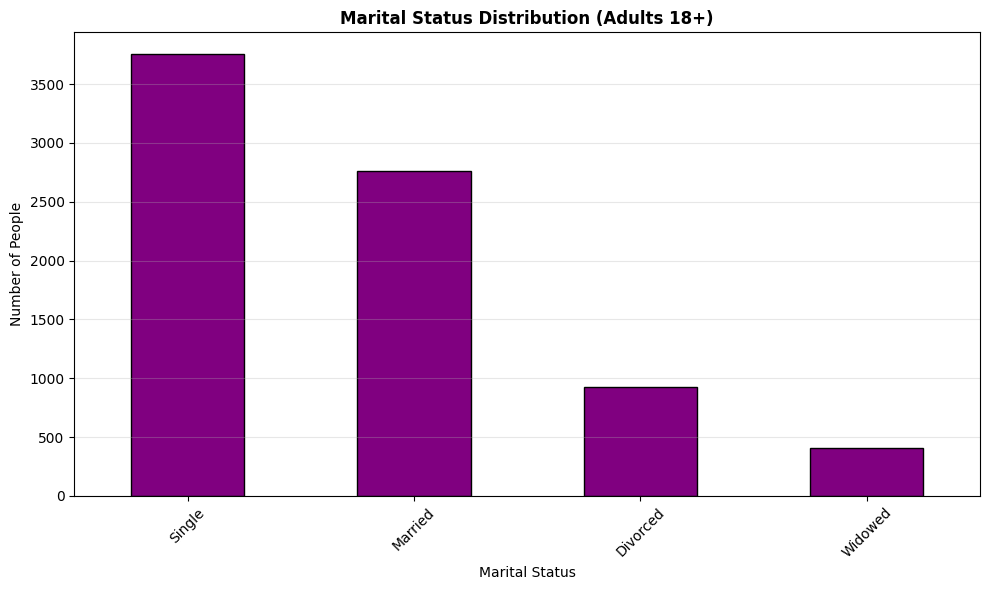

Figure 10: Distribution of marital status among adults.


In [368]:
# Marriage and divorce analysis
print("Marriage and divorce analysis")
# Only look at adults (18+)
adults = df[df['Age'] >= 18]

# Count marital status
marital_counts = adults['Marital Status'].value_counts()
print("\nMarital status of adults (18+):")
print(marital_counts)
print(f"\nTotal adults: {len(adults)}")

# Calculate rates
married = marital_counts.get('Married', 0)
divorced = marital_counts.get('Divorced', 0)
single = marital_counts.get('Single', 0)
widowed = marital_counts.get('Widowed', 0)

print(f"\nMarriage rate: {married/len(adults)*100:.1f}%")
print(f"Divorce rate: {divorced/len(adults)*100:.1f}%")
print(f"Single rate: {single/len(adults)*100:.1f}%")
print(f"Widowed rate: {widowed/len(adults)*100:.1f}%")

# Visualization
plt.figure(figsize=(10, 6))
marital_counts.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Marital Status Distribution (Adults 18+)', fontsize=12, fontweight='bold')
plt.xlabel('Marital Status', fontsize=10)
plt.ylabel('Number of People', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 10: Distribution of marital status among adults.")

Housing occupancy analysis

Average household size: 3.06 people
Median household size: 3.00 people
Minimum household size: 1 people
Maximum household size: 22 people

Occupancy levels:
  Under-used (1-2 people): 1534 households (44.3%)
  Normal use (3-4 people): 1306 households (37.7%)
  Over-used (5+ people): 620 households (17.9%)


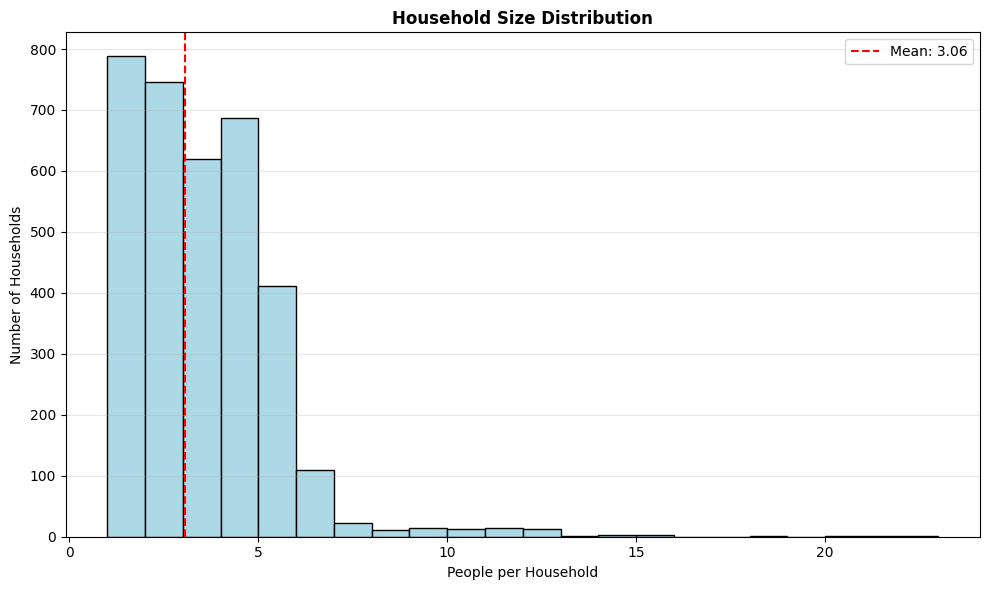

Figure 11: Distribution of household sizes showing occupancy levels.


In [367]:
# Housing occupancy analysis
print("Housing occupancy analysis\n")
household_sizes = df.groupby(['Street', 'House Number']).size()

print(f"Average household size: {household_sizes.mean():.2f} people")
print(f"Median household size: {household_sizes.median():.2f} people")
print(f"Minimum household size: {household_sizes.min()} people")
print(f"Maximum household size: {household_sizes.max()} people")

# Analyze occupancy levels
# Typically: 1-2 = under-used, 3-4 = normal, 5+ = over-used
under_used = (household_sizes <= 2).sum()
normal_use = ((household_sizes >= 3) & (household_sizes <= 4)).sum()
over_used = (household_sizes >= 5).sum()

print(f"\nOccupancy levels:")
print(f"  Under-used (1-2 people): {under_used} households ({under_used/len(household_sizes)*100:.1f}%)")
print(f"  Normal use (3-4 people): {normal_use} households ({normal_use/len(household_sizes)*100:.1f}%)")
print(f"  Over-used (5+ people): {over_used} households ({over_used/len(household_sizes)*100:.1f}%)")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(household_sizes, bins=range(1, int(household_sizes.max())+2), edgecolor='black', color='lightblue')
plt.axvline(household_sizes.mean(), color='red', linestyle='--', label=f'Mean: {household_sizes.mean():.2f}')
plt.title('Household Size Distribution', fontsize=12, fontweight='bold')
plt.xlabel('People per Household', fontsize=10)
plt.ylabel('Number of Households', fontsize=10)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Figure 11: Distribution of household sizes showing occupancy levels.")

## Recommendation and Justification

### Recommended Development: Train Station

Based on analysis of the census data, **a train station is recommended** as the most appropriate development for the unoccupied plot of land.


### Justification

#### Key Findings

**80.1% of the population are potential commuters** (8,486 out of 10,594 people):
- 27.4% are students (2,904 people) who commute to nearby cities
- 52.7% are employed (5,582 people) who need to travel for work

The age pyramid analysis shows 64.3% of the population are of working age (18-64), supporting the high commuter need.

#### Why This is the Priority

- **Largest need**: 80.1% would benefit vs. 52.6% (high-density housing), 12.3% (low-density), 41% (religious), or 0.8% (medical)
- **Infrastructure relief**: Would relieve road pressure on motorways
- **Town context**: Located between two larger cities, making transport essential
- **Population structure**: Age pyramid shows large working-age population requiring transport

#### Comparison with Other Options

- **High-density housing**: 52.6% are young/kids, but transport is more urgent for existing residents. Housing occupancy shows 44.3% under-used households, suggesting capacity exists.
- **Low-density housing**: Only 12.3% have high-income jobs; occupancy analysis shows 37.7% normal use, indicating current housing is adequate
- **Religious building**: Only 41% have religion, already have Catholic place
- **Emergency medical**: Only 0.8% have infirmities, too low to justify

### Conclusion

The train station is recommended because it addresses the most critical need affecting 80.1% of the population, which is significantly higher than any other option. The age structure analysis confirms a large working-age population that requires reliable transport infrastructure.


-- -- -- -- -- -- -- --

### (b) Which one of the following options should be invested in?

The options to consider are:

1. **Employment and training** - If there is evidence for a significant amount of unemployment
2. **Old age care** - If there is evidence that there will be an increased number of retired people in future years
3. **Increase spending for schooling** - If there is evidence of a growing population of school-aged children
4. **General infrastructure** - If the town is expanding

We will analyze each option using the census data.

In [356]:
# Option 1: Employment and Training
print("Employment and training\n")
# Check for unemployed people
unemployed = df[df['Occupation'].str.contains('unemployed|Unemployed', case=False, na=False)]
print(f"Unemployed: {len(unemployed)} ({len(unemployed)/len(df)*100:.1f}%)")

# Also check people without occupation (might be unemployed)
no_occupation = df[df['Occupation'].isna()]
print(f"People with no occupation listed: {len(no_occupation)} ({len(no_occupation)/len(df)*100:.1f}%)")

# Total potential unemployed (unemployed + no occupation, but exclude kids and students)
# Actually, let's just look at unemployed adults
unemployed_adults = unemployed[unemployed['Age'] >= 18]
print(f"Unemployed adults (18+): {len(unemployed_adults)} ({len(unemployed_adults)/len(df)*100:.1f}%)")

Employment and training

Unemployed: 656 (6.2%)
People with no occupation listed: 3 (0.0%)
Unemployed adults (18+): 656 (6.2%)


In [357]:
# Option 2: Old Age Care
print("Old age care\n")
# Current retired/elderly population
elderly = df[df['Age'] >= 65]
print(f"Current elderly (65+): {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")

# People close to retirement (55-64) - will be elderly soon
near_retirement = df[(df['Age'] >= 55) & (df['Age'] < 65)]
print(f"Near retirement (55-64): {len(near_retirement)} ({len(near_retirement)/len(df)*100:.1f}%)")

# Check retired people by occupation
retired = df[df['Occupation'].str.contains('retired|Retired', case=False, na=False)]
print(f"Retired (by occupation): {len(retired)} ({len(retired)/len(df)*100:.1f}%)")

# Future elderly (people 50-64 who will be 65+ in next 15 years)
future_elderly = df[(df['Age'] >= 50) & (df['Age'] < 65)]
print(f"Future elderly (50-64, will be 65+ in 15 years): {len(future_elderly)} ({len(future_elderly)/len(df)*100:.1f}%)")

Old age care

Current elderly (65+): 1044 (9.9%)
Near retirement (55-64): 1030 (9.7%)
Retired (by occupation): 783 (7.4%)
Future elderly (50-64, will be 65+ in 15 years): 1658 (15.7%)


In [358]:
# Option 3: Increase Spending for Schooling
print("Increase spending for schooling\n")
# School-aged children (typically 5-18)
school_age = df[(df['Age'] >= 5) & (df['Age'] < 18)]
print(f"School-aged children (5-17): {len(school_age)} ({len(school_age)/len(df)*100:.1f}%)")

# Younger children (0-4) who will enter school soon
pre_school = df[df['Age'] < 5]
print(f"Pre-school children (0-4): {len(pre_school)} ({len(pre_school)/len(df)*100:.1f}%)")

# Total children
all_children = df[df['Age'] < 18]
print(f"All children (<18): {len(all_children)} ({len(all_children)/len(df)*100:.1f}%)")

# Check for students (might indicate education needs)
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
print(f"Students: {len(students)} ({len(students)/len(df)*100:.1f}%)")


Increase spending for schooling

School-aged children (5-17): 2100 (19.8%)
Pre-school children (0-4): 645 (6.1%)
All children (<18): 2745 (25.9%)
Students: 2904 (27.4%)


In [359]:
# Option 4: General Infrastructure
print("General infrastructure\n")
# Check if town is expanding - look at age distribution
# Young people indicate growth
young_adults = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
print(f"Young adults (18-35): {len(young_adults)} ({len(young_adults)/len(df)*100:.1f}%)")

# Children indicate families moving in
children = df[df['Age'] < 18]
print(f"Children (<18): {len(children)} ({len(children)/len(df)*100:.1f}%)")

# Total population growth indicators
growth_indicators = len(young_adults) + len(children)
print(f"Total growth indicators: {growth_indicators} ({growth_indicators/len(df)*100:.1f}%)")

# Check household numbers - more households = expansion
households = df.groupby(['Street', 'House Number']).ngroups
print(f"Total households: {households}")
print(f"Average household size: {len(df)/households:.2f}")


General infrastructure

Young adults (18-35): 2827 (26.7%)
Children (<18): 2745 (25.9%)
Total growth indicators: 5572 (52.6%)
Total households: 3460
Average household size: 3.06


In [360]:
# Summary comparison of all investment options
print("Summary comparison of all investment options")

# 1. Employment and Training
unemployed = df[df['Occupation'].str.contains('unemployed|Unemployed', case=False, na=False)]
unemployed_adults = unemployed[unemployed['Age'] >= 18]
print("\n1. EMPLOYMENT AND TRAINING:")
print(f"   Unemployed adults: {len(unemployed_adults)} ({len(unemployed_adults)/len(df)*100:.1f}%)")

# 2. Old Age Care
elderly = df[df['Age'] >= 65]
future_elderly = df[(df['Age'] >= 50) & (df['Age'] < 65)]
print("\n2. OLD AGE CARE:")
print(f"   Current elderly (65+): {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")
print(f"   Future elderly (50-64): {len(future_elderly)} ({len(future_elderly)/len(df)*100:.1f}%)")

# 3. Schooling
school_age = df[(df['Age'] >= 5) & (df['Age'] < 18)]
pre_school = df[df['Age'] < 5]
print("\n3. INCREASE SPENDING FOR SCHOOLING:")
print(f"   School-aged (5-17): {len(school_age)} ({len(school_age)/len(df)*100:.1f}%)")
print(f"   Pre-school (0-4): {len(pre_school)} ({len(pre_school)/len(df)*100:.1f}%)")
print(f"   Total children: {len(school_age) + len(pre_school)} ({(len(school_age) + len(pre_school))/len(df)*100:.1f}%)")

# 4. General Infrastructure
young_adults = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
children = df[df['Age'] < 18]
growth_indicators = len(young_adults) + len(children)
print("\n4. GENERAL INFRASTRUCTURE:")
print(f"   Growth indicators (young + children): {growth_indicators} ({growth_indicators/len(df)*100:.1f}%)")


Summary comparison of all investment options

1. EMPLOYMENT AND TRAINING:
   Unemployed adults: 656 (6.2%)

2. OLD AGE CARE:
   Current elderly (65+): 1044 (9.9%)
   Future elderly (50-64): 1658 (15.7%)

3. INCREASE SPENDING FOR SCHOOLING:
   School-aged (5-17): 2100 (19.8%)
   Pre-school (0-4): 645 (6.1%)
   Total children: 2745 (25.9%)

4. GENERAL INFRASTRUCTURE:
   Growth indicators (young + children): 5572 (52.6%)


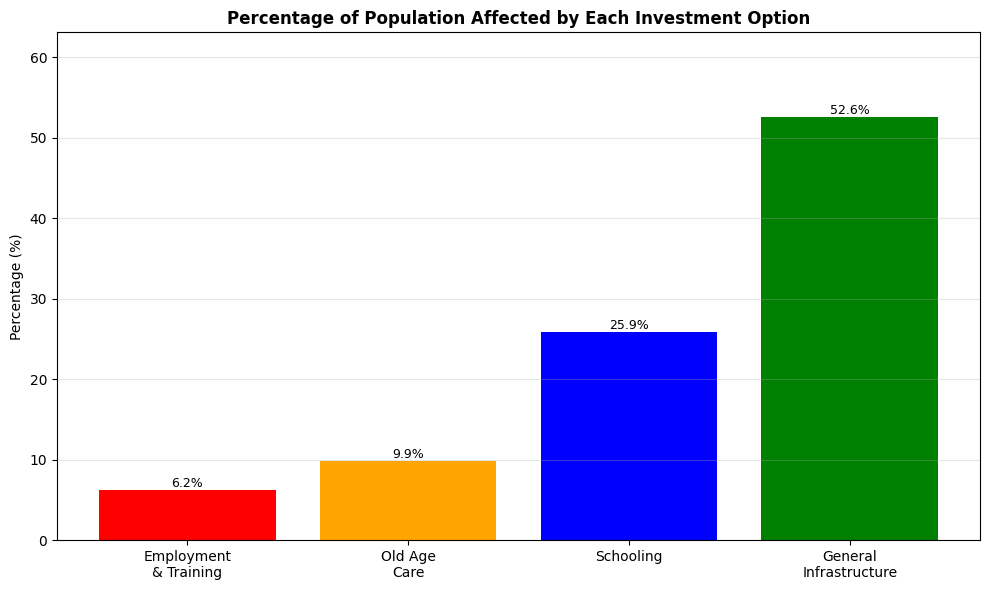

Figure 7: Comparison of investment options showing percentage of population affected.


In [361]:
# Visualization: Compare investment options
plt.figure(figsize=(10, 6))

# Calculate percentages for each option
unemployed = df[df['Occupation'].str.contains('unemployed|Unemployed', case=False, na=False)]
unemployed_adults = unemployed[unemployed['Age'] >= 18]
employment_pct = len(unemployed_adults) / len(df) * 100

elderly = df[df['Age'] >= 65]
elderly_pct = len(elderly) / len(df) * 100

school_age = df[(df['Age'] >= 5) & (df['Age'] < 18)]
pre_school = df[df['Age'] < 5]
schooling_pct = (len(school_age) + len(pre_school)) / len(df) * 100

young_adults = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
children = df[df['Age'] < 18]
infrastructure_pct = (len(young_adults) + len(children)) / len(df) * 100

# Create bar chart
options = ['Employment\n& Training', 'Old Age\nCare', 'Schooling', 'General\nInfrastructure']
percentages = [employment_pct, elderly_pct, schooling_pct, infrastructure_pct]
colors = ['red', 'orange', 'blue', 'green']

bars = plt.bar(options, percentages, color=colors)
plt.title('Percentage of Population Affected by Each Investment Option', fontsize=12, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=10)
plt.ylim(0, max(percentages) * 1.2)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print("Figure 7: Comparison of investment options showing percentage of population affected.")


## Recommendation and Justification for Question (b)

### Recommended Investment: General Infrastructure

Based on analysis of the census data, **general infrastructure** is recommended as the priority investment.


### Justification

#### Key Findings

**52.6% of the population are growth indicators** (5,572 out of 10,594 people):
- 26.7% are young adults (18-35)
- 25.9% are children (<18)

The age pyramid analysis confirms this growth pattern, showing a large proportion of young people and children relative to elderly (9.9%).

#### Why This is the Priority

- **Largest affected population**: 52.6% would benefit from infrastructure investment
- **Town expansion**: Age pyramid shows expanding population structure with many young adults and children
- **Housing occupancy**: 44.3% of households are under-used (1-2 people), suggesting potential for growth as families expand
- **Infrastructure needs**: Expanding population requires more services (waste collection, road maintenance, etc.)
- **Future planning**: Investing now prepares for continued growth indicated by age structure

#### Comparison with Other Options

- **Employment and Training**: Only 6.2% unemployed adults - too low to be priority. Unemployment by age analysis shows rates are manageable across age groups.
- **Old Age Care**: 9.9% current elderly, 15.7% future elderly (50-64) - important but affects smaller portion (25.6% total) compared to growth indicators
- **Schooling**: 25.9% are children - significant but infrastructure affects everyone including these children and their families
- **General Infrastructure**: 52.6% affected - largest need by far, supported by age pyramid showing population expansion

### Conclusion

General infrastructure is recommended because it addresses the needs of 52.6% of the population, which is the largest affected group. The age pyramid analysis confirms the town is expanding with many young adults and children, and housing occupancy data shows capacity for growth. This makes infrastructure investment essential for waste collection, road maintenance, and other services to support the growing population.
